In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
from google.colab import files 

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/FilipAndersson245/cartoon-gan

Cloning into 'cartoon-gan'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 94 (delta 31), reused 69 (delta 29), pack-reused 21
Unpacking objects: 100% (94/94), done.


In [ ]:
!pip install tqdm pillow numpy matplotlib opencv-python

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CyclicLR
import torchvision.utils as vutils

from utils.loss import ContentLoss, AdversialLoss
from utils.transforms import get_default_transforms, get_no_aug_transform
from utils.datasets import get_dataloader
from utils.transforms import get_pair_transforms
from torch.utils.tensorboard import SummaryWriter
from models.discriminator import Discriminator
from models.generator import Generator

from datetime import datetime
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os

ModuleNotFoundError: ignored

In [ ]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # Config
    batch_size = 4
    image_size = 256
    learning_rate = 1e-3
    beta1, beta2 = (.5, .99)
    weight_decay = 1e-3
    epochs = 100

    # Models
    netD = Discriminator().to(device)
    netG = Generator().to(device)

    optimizerD = AdamW(netD.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
    optimizerG = AdamW(netG.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)

    # Labels
    cartoon_labels = torch.ones (batch_size, 1, image_size // 4, image_size // 4).to(device)
    fake_labels    = torch.zeros(batch_size, 1, image_size // 4, image_size // 4).to(device)

    # Loss functions
    content_loss = ContentLoss().to(device)
    adv_loss     = AdversialLoss(cartoon_labels, fake_labels).to(device)
    BCE_loss     = nn.BCELoss().to(device)

    # Dataloaders
    real_dataloader    = get_dataloader("/content/drive/MyDrive/Colab/pic2anime/trainA",           size = image_size, bs = batch_size)
    cartoon_dataloader = get_dataloader("/content/drive/MyDrive/Colab/pic2anime/trainB",        size = image_size, bs = batch_size)
    edge_dataloader    = get_dataloader("/content/drive/MyDrive/Colab/pic2anime/trainB_smooth", size = image_size, bs = batch_size)
    last_epoch = 0
    last_i = 0
    # --------------------------------------------------------------------------------------------- #
    # Training Loop
    tracked_images = next(iter(real_dataloader))[0].to(device)
    original_images = tracked_images.detach().cpu()
    grid = vutils.make_grid(original_images, padding=2, normalize=True, nrow=3)
    plt.imsave(f"/content/cartoon-gan/results/original.png", np.transpose(grid, (1,2,0)).numpy())
    netG.load_state_dict(torch.load("_trained_netG32.pth"))
    netD.load_state_dict(torch.load("_trained_netD32.pth"))
    with open("iter_data32.pickle", "rb") as handle:
      last_epoch, last_i = pickle.load(handle)

    
    # Lists to keep track of progress"
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    start_epoch = last_epoch
    start_i = last_i


    print("Starting Training Loop...")
    # For each epoch.
    for epoch in range(start_epoch,epochs):
        # For each batch in the dataloader.
        real_dl_iter = iter(real_dataloader)
        cartoon_dl_iter = iter(cartoon_dataloader)
        edge_dl_iter = iter(edge_dataloader)
        iterations =  min(len(real_dl_iter), len(cartoon_dl_iter))
        for i in range(start_i,iterations):
            real_data = next(real_dl_iter)
            cartoon_data = next(cartoon_dl_iter)
            edge_data = next(edge_dl_iter)
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            
            # Reset Discriminator gradient.
            netD.zero_grad()

            # Format batch.
            cartoon_data   = cartoon_data.to(device)
            edge_data      = edge_data.to(device)
            real_data      = real_data.to(device)

            # Generate image
            generated_data = netG(real_data)

            # Forward pass all batches through D.
            cartoon_pred   = netD(cartoon_data)      #.view(-1)
            edge_pred      = netD(edge_data)         #.view(-1)
            generated_pred = netD(generated_data)    #.view(-1)

            print(generated_data.is_cuda, real_data.is_cuda)

            # Calculate discriminator loss on all batches.
            errD = adv_loss(cartoon_pred, generated_pred, edge_pred)
            
            # Calculate gradients for D in backward pass
            errD.backward(retain_graph=True)
            D_x = cartoon_pred.mean().item() # Should be close to 1

            # Update D
            optimizerD.step()


            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            
            # Reset Generator gradient.
            netG.zero_grad()
            
            # Since we just updated D, perform another forward pass of all-fake batch through D
            generated_pred = netD(generated_data) #.view(-1)

            # Calculate G's loss based on this output
            print(generated_data.is_cuda, real_data.is_cuda)
            print("generated_pred:", generated_pred.is_cuda, "cartoon_labels:", cartoon_labels.is_cuda)
            errG = BCE_loss(generated_pred, cartoon_labels) + content_loss(generated_data, real_data)

            # Calculate gradients for G
            errG.backward()

            D_G_z2 = generated_pred.mean().item() # Should be close to 1
            
            # Update G
            optimizerG.step()
            
            # ---------------------------------------------------------------------------------------- #

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): null / %.4f'
                    % (epoch, epochs, i, len(real_dataloader),
                        errD.item(), errG.item(), D_x, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on tracked_images
            if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    
                    fake = netG(tracked_images.unsqueeze(0)).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
            last_i = i
        start_i = 0
        last_epoch = epoch
        torch.save(netG.state_dict(), "_trained_netG"+str(epoch)+".pth")
        torch.save(netD.state_dict(), "_trained_netD"+str(epoch)+".pth")
        files.download("_trained_netG"+str(epoch)+".pth")
        files.download("_trained_netD"+str(epoch)+".pth")
        with open("iter_data"+str(epoch)+".pickle", "wb") as handle:
           pickle.dump([last_epoch, last_i], handle)
           print("file saved")
           files.download("iter_data"+str(epoch)+".pickle")
         

In [ ]:
if __name__ == "__main__":
    train()

In [ ]:
pwd

'/content'

In [ ]:
cd cartoon-gan/

/content/cartoon-gan


In [ ]:
!python predict.py -i '/content/cartoon-gan/data' -o '/content/output_folder/output_image9.png'

Processing files:  82% 118/144 [00:04<00:00, 27.21it/s]
Traceback (most recent call last):
  File "predict.py", line 112, in <module>
    predict_file(file_path, output_file_path)
  File "predict.py", line 56, in predict_file
    predicted_image = predict_images([image])[0]
  File "predict.py", line 36, in predict_images
    generated_images = inv_normalize(generated_images)
  File "predict.py", line 23, in inv_normalize
    mean = torch.Tensor([0.485+0.1, 0.456+0.1, 0.406+0.1]).to(device)
KeyboardInterrupt


In [ ]:
pip install ffmpeg

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.png', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.png


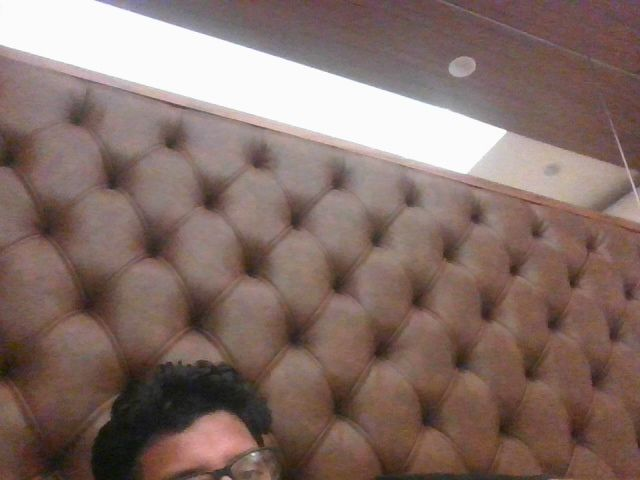

True
Traceback (most recent call last):
  File "predict.py", line 108, in <module>
    predict_file(input_path, output_path)
  File "predict.py", line 66, in predict_file
    subprocess.run("ffmpeg -i \"{input_path}\" \"{os.path.join(temp_dir.name, 'frame_%07d.png')}\"")
  File "/usr/lib/python3.7/subprocess.py", line 488, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/usr/lib/python3.7/subprocess.py", line 800, in __init__
    restore_signals, start_new_session)
  File "/usr/lib/python3.7/subprocess.py", line 1551, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg -i "{input_path}" "{os.path.join(temp_dir.name, \'frame_%07d.png\')}"': 'ffmpeg -i "{input_path}" "{os.path.join(temp_dir.name, \'frame_%07d.png\')}"'


In [ ]:
 from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
!python predict.py -i /content/hey/video.mp4 -o /content/output_folder_video
display(Image('/content/output_folder/output_image4.png'))

In [ ]:
!pip install ffmpeg-python

In [ ]:
# Adapted from: https://stackoverflow.com/a/62804023/4879610
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename):
  js = Javascript("""
    async function recordVideo() {
      // mashes together the advanced_outputs.ipynb function provided by Colab, 
      // a bunch of stuff from Stack overflow, and some sample code from:
      // https://developer.mozilla.org/en-US/docs/Web/API/MediaStream_Recording_API

      // Optional frames per second argument.
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
      // create a media recorder instance, which is an object
      // that will let you record what you stream.
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      // Video is a media element.  This line here sets the object which serves
      // as the source of the media associated with the HTMLMediaElement
      // Here, we'll set it equal to the stream.
      video.srcObject = stream;

      // from https://stackoverflow.com/questions/62529304/is-there-any-way-to-capture-live-video-using-webcam-in-google-colab#comment114644726_62804023
      video.muted = true;

      // We're inside an async function, so this await will fire off the playing
      // of a video. It returns a Promise which is resolved when playback has 
      // been successfully started. Since this is async, the function will be 
      // paused until this has started playing. 
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // and now, just wait for the capture button to get clicked in order to
      // start recording
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      // use a promise to tell it to stop recording
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);

    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):
  # show saved video in colab.
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
video_path = "test1.mp4"
record_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video. Saved binary under filename in current working directory: test1.mp4


In [ ]:
show_video("video.mp4")

FileNotFoundError: ignored

In [ ]:
cd videoshiz/

/content/cartoon-gan/videoshiz


In [ ]:

import cv2
import numpy as np

cap = cv2.VideoCapture('/content/cartoon-gan/test1.mp4')
if (cap.isOpened()== False):
  print("Error opening video stream or file")
count = 0
while(cap.isOpened()):
  count+=1
  ret, frame = cap.read()
  if ret == True:
    cv2.imwrite("frame%d.jpg" % count,frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
  else:
    break
cap.release()
cv2.destroyAllWindows()

In [ ]:
cd '/content/'


/content


In [ ]:
!python predict.py -i '/content/cartoon-gan/videoshiz' -o '/content/output_folder/videoanime'

Processing files:  32% 76/238 [00:02<00:05, 27.80it/s]
Traceback (most recent call last):
  File "predict.py", line 112, in <module>
    predict_file(file_path, output_file_path)
  File "predict.py", line 54, in predict_file
    if mimetypes.guess_type(input_path)[0].startswith("image"):
AttributeError: 'NoneType' object has no attribute 'startswith'


In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join


def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        print(filename)
        cv2.resize(img, (480, 640))
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
def main():
    pathIn= './output_folder/videoanime/'
    pathOut = './video3.avi'
    fps = 25.0
    convert_frames_to_video(pathIn, pathOut, fps)
if __name__=="__main__":
    main()

./output_folder/videoanime/frame1.jpg
./output_folder/videoanime/frame1.jpg
./output_folder/videoanime/frame2.jpg
./output_folder/videoanime/frame2.jpg
./output_folder/videoanime/frame4.jpg
./output_folder/videoanime/frame4.jpg
./output_folder/videoanime/frame6.jpg
./output_folder/videoanime/frame6.jpg
./output_folder/videoanime/frame7.jpg
./output_folder/videoanime/frame7.jpg
./output_folder/videoanime/frame8.jpg
./output_folder/videoanime/frame8.jpg
./output_folder/videoanime/frame9.jpg
./output_folder/videoanime/frame9.jpg
./output_folder/videoanime/frame10.jpg
./output_folder/videoanime/frame10.jpg
./output_folder/videoanime/frame11.jpg
./output_folder/videoanime/frame11.jpg
./output_folder/videoanime/frame12.jpg
./output_folder/videoanime/frame12.jpg
./output_folder/videoanime/frame13.jpg
./output_folder/videoanime/frame13.jpg
./output_folder/videoanime/frame14.jpg
./output_folder/videoanime/frame14.jpg
./output_folder/videoanime/frame15.jpg
./output_folder/videoanime/frame15.jpg


In [ ]:
filename = './output_folder/output1/frame73.jpg'
img1 = cv2.imread(filename)
img1.shape

(256, 256, 3)

In [ ]:
filename1 = './data/frame144.jpg'
img2 = cv2.imread(filename1)
img2.shape

(480, 640, 3)

In [ ]:
cv2.resize(image, (480, 640))